# Competitive inhibition of transcription using STYX

In [1]:
#| output: true
import yaml
import os
import sys
import glob
import shutil
sys.path.append('..')

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["font.size"] = 11

import seaborn as sns

from analyze_data import result

with open('python_config.yml') as configfile:
    config = yaml.safe_load(configfile)

name = 'styx'

figure_params = config['figure_params']
data_path = os.path.join(config['data_path'],config['data_folders'][name])
print(os.listdir(data_path))

['3-T1', 'Figure4', 'Flourometry', 'WB']


In [2]:
def copy_files(path, n = name, d = data_path):
    if '../data/' in path:
        return path
    ending = path.split(d)[1][1:]
    new_file = os.path.join('../data',n,ending)
    if os.path.exists(new_file):
        return new_file
    else:
        folder = ending.split(os.path.basename(ending))[0][:-1]
        full_folder = os.path.join('../data',n,folder)
        if not os.path.exists(full_folder):
            os.makedirs(full_folder)
        shutil.copy(path, new_file)
        return new_file

def get_new_folder(path, n = name, d = data_path):
    ending = path.split(d)[1][1:]
    new_folder = os.path.join('../data',n,ending)
    return new_folder

## Flourometry

In [3]:
#| output: true
fluor_path = os.path.join(data_path, 'Flourometry')

def load_spark(path, 
               spark_name = 'Spark.xlsx',
               group_name = 'Group1.csv', 
               bradford_name = 'Bradford.xlsx', 
               brad_lab_name = 'BradLab.csv'):
    spark_df = (pd.read_excel(copy_files(os.path.join(path,spark_name)), skiprows=48, nrows = 7)
         .rename(columns = {'Well': 'measurement'})
         .set_index('measurement').T)
    uppercase_letters = [chr(x) for x in range(ord('A'), ord('H')+1)]

    group_df = pd.read_csv(copy_files(os.path.join(path,group_name)), header = None, delimiter=';')
    group_df['letter'] = uppercase_letters
    group_df = group_df.melt(id_vars = 'letter', value_name='group')
    group_df['variable'] = group_df['variable']+1
    group_df['Well'] = group_df['letter'] + group_df['variable'].astype(str)
    group = group_df.astype(str).loc[group_df['group'].astype(str) != '0',['Well','group']].set_index('Well')

    bradlab = pd.read_csv(copy_files(os.path.join(path,brad_lab_name)), header = None, delimiter=';')
    bradlab['letter'] = uppercase_letters
    bradlab = bradlab.melt(id_vars = 'letter', value_name='spark_wells')
    bradlab['variable'] = bradlab['variable']+1
    bradlab['Well'] = bradlab['letter'] + bradlab['variable'].astype(str)
    bradlab = bradlab.loc[bradlab['spark_wells'].astype(str) != '0',['Well','spark_wells']].set_index('Well')

    bradford = (pd.read_excel(copy_files(os.path.join(path,bradford_name)), skiprows=9, nrows = 9)
            .set_index('Abs')
            .melt(ignore_index=False, value_name='bradford')
            .reset_index())
    bradford['bradlab'] = bradford['Abs'] + bradford['variable'].astype(str)
    bradford = bradford.dropna().set_index('bradlab')[['bradford']].join(bradlab, how = 'inner').set_index('spark_wells')
    
    fluor_df = spark_df.join(group, how = 'inner').join(bradford, how = 'left')
    return fluor_df

def get_fluorometry_result(df, var = 'Mean', blank = 'NT', control = 'X'):
    df['mean_sub'] = df[var] - df.loc[df['group']== blank,var].mean()
    df['mean_rel'] = df['mean_sub']/df['bradford']
    df['mean_norm'] = df['mean_rel']/df.loc[df['group']== 'X','mean_rel'].mean()
    result = df.loc[df['group']!='NT',['mean_norm','group']]
    return result.sort_values('group', ascending = False)

print(os.listdir(fluor_path))

['Results.csv', '1', '2', '3', '4']


### Attempt 1
#### Seeding (28.11.2022)
- Seed 15.000 HeLa cells per well in 96 Well (diluted in 100µL DMEM)
- Layout:
    - 4 Wells reserved for Blank measurement (termed NT)
    - 4 Wells per row per condition:
        Conditions: X, TP, FY
#### Transfection (29.11.2022)
- Change Media beforehand
- Transfect in a 1:2 manner (Plasmid1:Plasmid2)
- 0.1µg total amount of Plasmid per Well
- Conditions:
    - X: P1 = GFP, P2 = STYX
    - TP: P1 = GFP, P2 = TP-Linker-Protein
    - FY: P1 = GFP, P2 = FY-Linker-Protein
- Change Media 4h after Transfection
#### Measurement (30.11.2022)
- Change Media to 100µL PBS
- Measure with Spark @ 488nm
- Incubate on ice for 20mins
- Replace PBS with 10µL RIPA(+PI)
- Incubate for 20mins
- Take out 10µL of cell lysate into new 96-Well
- Put in 150mL of Bradford-assay
- Measure @ 660nM
#### Results
The mean value of all 5 measurements in each well is calculated. The intensity of the blank measurement is subtracted. Then the resulting value is divided by the measured protein concentration and then further normalised to the mean of the control.

In [4]:
fluor_one_path = os.path.join(fluor_path, '1')

fluor_one_df = load_spark(fluor_one_path)
fluor_one_result = get_fluorometry_result(fluor_one_df)

display(fluor_one_result.groupby('group')['mean_norm'].agg(['mean','std','count']).round(3).sort_index(ascending = False))

,mean,std,count
group,,,
X,1.000,0.043,4
TP,0.549,0.097,4
FY,0.585,0.157,4


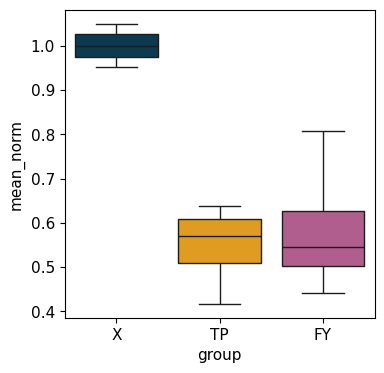

In [5]:
fig = plt.figure(figsize = (4,4))
sns.boxplot(data = fluor_one_result, x = 'group', y = 'mean_norm', hue = 'group', legend = False, palette = figure_params['palette'])
plt.show()

### Attempt 2
#### Seeding (23.08.2022)
- Seed 15.000 HeLa cells per well in 96 Well (diluted in 100µL DMEM)
- Layout:
    - 4 Wells reserved for Blank measurement (termed NT)
    - 4 Wells per row per condition:
        Conditions: X, TP, FY
#### Transfection (24.08.2022)
- Change Media beforehand
- Transfect in a 1:2 manner (Plasmid1:Plasmid2)
- 0.1µg total amount of Plasmid per Well
- Conditions:
    - X: P1 = GFP, P2 = STYX
    - TP: P1 = GFP, P2 = TP-Linker-Protein
    - FY: P1 = GFP, P2 = FY-Linker-Protein
- Change Media 4h after Transfection
#### Measurement (25.08.2022)
- Change Media to 100µL PBS
- Measure with Spark @ 488nm
- Incubate on ice for 20mins
- Replace PBS with 10µL RIPA(+PI)
- Incubate for 20mins
- Take out 10µL of cell lysate into new 96-Well
- Put in 150mL of Bradford-assay
- Measure @ 660nM
#### Results
The mean value of all 5 measurements in each well is calculated. The intensity of the blank measurement is subtracted. Then the resulting value is divided by the measured protein concentration and then further normalised to the mean of the control.

In [6]:
fluor_two_path = os.path.join(fluor_path, '2')

fluor_two_df = load_spark(fluor_two_path)
fluor_two_result = get_fluorometry_result(fluor_two_df)

display(fluor_two_result.groupby('group')['mean_norm'].agg(['mean','std','count']).round(3).sort_index(ascending = False))

,mean,std,count
group,,,
X,1.000,0.021,3
TP,0.342,0.023,3
FY,0.409,0.076,3


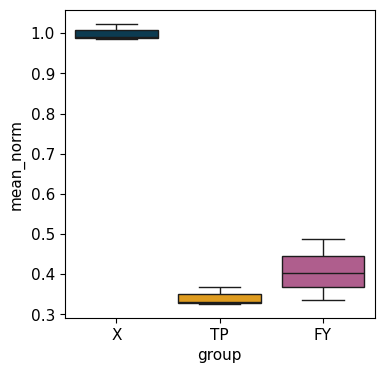

In [7]:
fig = plt.figure(figsize = (4,4))
sns.boxplot(data = fluor_two_result, x = 'group', y = 'mean_norm', hue = 'group', legend = False, palette = figure_params['palette'])
plt.show()

### Attempt 3
#### Seeding (05.12.2022)
- Seed 15.000 HeLa cells per well in 96 Well (diluted in 100µL DMEM)
- Layout:
    - 4 Wells reserved for Blank measurement (termed NT)
    - 4 Wells per row per condition:
        Conditions: X, TP, FY

#### Transfection (06.12.2022)
- Change Media beforehand
- Transfect in a 1:2 manner (Plasmid1:Plasmid2)
- 0.1µg total amount of Plasmid per Well
- Conditions:
    - X: P1 = GFP, P2 = STYX
    - TP: P1 = GFP, P2 = TP-Linker-Protein
    - FY: P1 = GFP, P2 = FY-Linker-Protein
- Change Media 4h after Transfection

#### Measurement (07.12.2022)
- Change Media to 100µL PBS
- Measure with Spark @ 488nm
- Incubate on ice for 20mins
- Replace PBS with 10µL RIPA(+PI)
- Incubate for 20mins
- Take out 10µL of cell lysate into new 96-Well
- Put in 150mL of Bradford-assay
- Measure @ 660nM

#### Results
The mean value of all 5 measurements in each well is calculated. The intensity of the blank measurement is subtracted. Then the resulting value is divided by the measured protein concentration and then further normalised to the mean of the control.

In [8]:
fluor_three_path = os.path.join(fluor_path, '3')

fluor_three_df = load_spark(fluor_three_path)
fluor_three_result = get_fluorometry_result(fluor_three_df)

display(fluor_three_result.groupby('group')['mean_norm'].agg(['mean','std','count']).round(3).sort_index(ascending = False))

,mean,std,count
group,,,
X,1.000,0.175,4
TP,0.350,0.059,4
FY,0.749,0.073,4


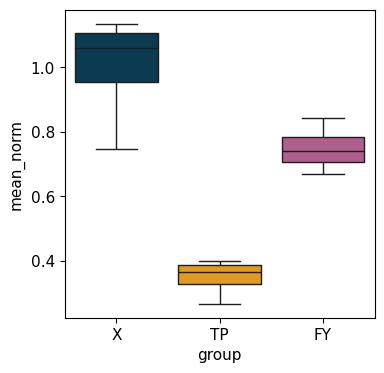

In [9]:
fig = plt.figure(figsize = (4,4))
sns.boxplot(data = fluor_three_result, x = 'group', y = 'mean_norm', hue = 'group', legend = False, palette = figure_params['palette'])
plt.show()

### Attempt 4
#### Seeding (06.12.2022)
- Seed 15.000 HeLa cells per well in 96 Well (diluted in 100µL DMEM)
- Layout:
    - 4 Wells reserved for Blank measurement (termed NT)
    - 4 Wells per row per condition:
        Conditions: X, TP, FY
        
#### Transfection (07.12.2022)
- Change Media beforehand
- Transfect in a 1:2 manner (Plasmid1:Plasmid2)
- 0.1µg total amount of Plasmid per Well
- Conditions:
    - X: P1 = GFP, P2 = STYX
    - TP: P1 = GFP, P2 = TP-Linker-Protein
    - FY: P1 = GFP, P2 = FY-Linker-Protein
- Change Media 4h after Transfection

#### Measurement (08.12.2022)
- Change Media to 100µL PBS
- Measure with Spark @ 488nm
- Incubate on ice for 20mins
- Replace PBS with 10µL RIPA(+PI)
- Incubate for 20mins
- Take out 10µL of cell lysate into new 96-Well
- Put in 150mL of Bradford-assay
- Measure @ 660nM

#### Results
The mean value of all 5 measurements in each well is calculated. The intensity of the blank measurement is subtracted. Then the resulting value is divided by the measured protein concentration and then further normalised to the mean of the control.

In [10]:
fluor_four_path = os.path.join(fluor_path, '4')
#print(pd.read_excel(os.path.join(fluor_four_path, 'Spark.xlsx')))

fluor_four_df = load_spark(fluor_four_path)
fluor_four_result = get_fluorometry_result(fluor_four_df)

display(fluor_four_result.groupby('group')['mean_norm'].agg(['mean','std','count']).round(3).sort_index(ascending = False))

,mean,std,count
group,,,
X,1.000,0.188,4
TP,0.461,0.082,4
FY,0.548,0.139,4


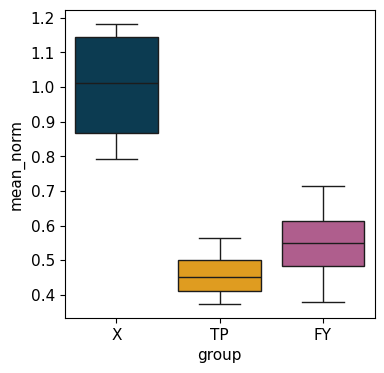

In [11]:
fig = plt.figure(figsize = (4,4))
sns.boxplot(data = fluor_four_result, x = 'group', y = 'mean_norm', hue = 'group', legend = False, palette = figure_params['palette'])
plt.show()

### Final Result

In [12]:
fluor_df = pd.concat([fluor_one_result,fluor_two_result,fluor_three_result,fluor_four_result], ignore_index = True)
fluor_result = result(df = fluor_df)
fluor_summary = fluor_result.summarize(groups=['group'],values = 'mean_norm').round(3)
display(fluor_summary)

,mean,sd,ci_lo,ci_hi,count
group,,,,,
X,1.000,0.117,0.936,1.057,15
TP,0.431,0.106,0.377,0.485,15
FY,0.583,0.156,0.501,0.664,15


In [13]:
fluor_p = fluor_result.create_p_table().set_index('group').round(3)

fluor_summary['mean [CI]'] = fluor_summary['mean'].astype(str) + ' [' + fluor_summary['ci_lo'].astype(str) + ', ' + fluor_summary['ci_hi'].astype(str) +']'

fluor_final = fluor_summary.loc[:,['mean [CI]']].join(fluor_p)
display(fluor_final.replace(np.nan, ''))

,mean [CI],p,star
group,,,
X,"1.0 [0.936, 1.057]",,
TP,"0.431 [0.377, 0.485]",0.0,****
FY,"0.583 [0.501, 0.664]",0.0,****


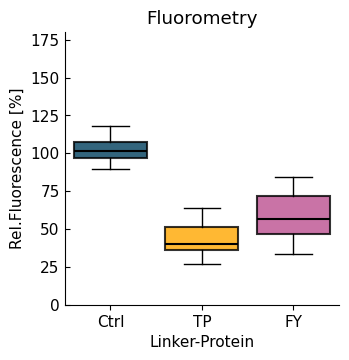

In [14]:
from matplotlib.ticker import AutoMinorLocator

def prettify_boxplot(ax, box, palette = ["#003f5c",
                     "#ffa600",
                     "#bc5090"]):

    for i, b in enumerate(box['boxes']):
        b.set_facecolor(palette[i%len(palette)])
        b.set_alpha(0.8)
        b.set_linewidth(1.5)
    for m in box['medians']:
      m.set(
        color = "black",
        linewidth = 1.5
      )
    ax.tick_params(bottom = True)
    ax.tick_params(which = "minor", left = False)
    return ax

def prettify(ax, *args,
             title = None,
             x = ("x-axis", ""),
             y = ("y-axis", ""),
             **kwargs):
    ax.set_title(title)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel(x[0] if len(x[1])==0 else f"{x[0]} [{x[1]}]")
    ax.set_ylabel(y[0] if len(y[1])==0 else f"{y[0]} [{y[1]}]")
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which = "both", 
                   direction = "in",
                  axis = 'y')
    return ax

def boxplot(data, 
            x=None, 
            y=None ,
            ax=None, 
            y_scale = 1,
            **kwargs):
    datalist = [data.loc[data[x]==xs, y].values * y_scale for xs in data.loc[:,x].unique()]
    box = ax.boxplot(datalist,
                    positions = range(len(datalist)),
                    patch_artist=True,
                    showfliers=False,
                    **kwargs
                )
    return ax, box

fig,ax = plt.subplots(figsize = (3.54,3.54))
ax, box = boxplot(data = fluor_df,
                 x = "group",
                 y = "mean_norm",
                 widths = 0.8,
                 y_scale = 100,
                 ax=ax)
ax = prettify(ax,
              title = "Fluorometry",
              x = ("Linker-Protein",""),
              y = ("Rel.Fluorescence","%"))
ax = prettify_boxplot(ax, box)
ax.set_xticklabels(["Ctrl","TP","FY"])
ax.set_ylim(0, 180)
plt.show()

## Western Blot

In [15]:
wb_path = os.path.join(data_path, 'WB')
os.listdir(wb_path)

def read_densitometry(path):
    wb_df = pd.read_csv(copy_files(os.path.join(path, 'Lanes.csv')), header = None).rename(columns = {0: 'group'})
    dens_folder = os.path.join(path, 'Densitometry')
    if os.path.exists(get_new_folder(os.path.join(path,'Densitometry'))):
        dens_folder = get_new_folder(os.path.join(path,'Densitometry'))
    for dens_file in glob.glob(os.path.join(dens_folder,'*.csv')):
        var = os.path.splitext(os.path.basename(dens_file))[0].split('_')[0]
        dens_df = pd.read_csv(copy_files(dens_file)).rename(columns = {'Area': var}).loc[:,var]
        wb_df = wb_df.join(dens_df)
    return wb_df

def normalize_dens(df, var = 'aSyn', loading_control = 'b-Actin', group = 'group', control = 'X'):
    df = df.set_index(group)
    df[f'{var}_rel'] = df[var]/df[loading_control]
    df[f'{var}_norm'] = df[f'{var}_rel']/df.loc[control,f'{var}_rel']
    return df

### Attempt 1
#### Seeding (03.12.2022)
- Seed 300.000 HeLa cells per well in 6 Well (diluted in 2mL DMEM)
- Layout:
    - 2 Wells per row per condition:
        Conditions: X, TP, FY

#### Transfection (04.12.2022)
- Change Media beforehand
- Transfect in a 1:2 manner (Plasmid1:Plasmid2)
- 0.1µg total amount of Plasmid per Well
- Conditions:
    - X: P1 = aSyn, P2 = STYX
    - TP: P1 = aSyn, P2 = TP-Linker-Protein
    - FY: P1 = aSyn, P2 = FY-Linker-Protein

- Change Media 4h after Transfection

#### Protein Extraction (05.12.2022)
- Change Media to 2mL PBS
- Incubate on ice for 20mins
- Replace PBS with 100µL RIPA(+PI)
- Incubate for 20mins
- Take out 100µL of cell lysate into 1.5mL Eppendorf tube
- Spin down @ max RPM for 20mins
- Take off 10µL for Protein Quantification:
    - Put into 96-Well
    - Put in BCA-Standard (3 Wells each)
    - Add 150µL Bradford-assay
    - Measure @660nm
    - Normalize volume:
        - Determine Volume to add to gel
        - Max Volume: 35µL for 10-slot comb, 25µL for 15-slot comb
        - Formula: Volume=(MaxV x MinC)/Conc
- Take off Supernatant
- Add LB
- Freeze

#### Western Blot (06.12.2022)
- Prepare 15% Polyacrylamide Gel
- Boil samples @97°C for 60s
- Add SizeMarker
- Add appropriate amounts of sample
- Run at 80V for 20mins
- Run as 130V until 10kD Marker at bottom
- Take out Gel and put into Transfer Buffer
- Transfer:
    - Put 5 Whattman Paper (WP) + Nitrocellulose membrane + Gel + 5 WP into Transfer-Machine
    - Run for 40mins
    - Take out membrane and out into TBST
    - Ponceau stain:
        - Stain with Ponceau S
        - Put back staining liquid into bottle
        - wash multiple times with H2O
        - Destain with TBST for 5mins
- Blocking:
    - Put Membrane into 5% Milk in TBST for 1h
- 1°AB - aSyn:
    - Put Anti-aSyn-AB into 5% BSA in TBST
    - Incubate Membrane in solution @ 4°C overnight
    
#### Imaging - GFP (07.12.2022)
- Wash in TBST for 3x for 5mins
- 2°AB - aSyn:
    - Put Anti-Mouse-AB into 5% Milk in TBST
    - Incubate Membrane in solution @ RT for 1h
- Wash in TBST for 3x for 5mins
- Add ECL to Membrane
- Image immediately
- Stripping:
    - Put Membrane in Stripping Buffer for 20mins
- Blocking:
    - Put Membrane into 5% Milk in TBST for 1h
- 1°AB - b-Actin:
    - Put Anti-b-Actin-AB into 5% BSA in TBST
    - Incubate Membrane in solution @ 4°C overnight
    
#### Imaging - b-Actin (08.12.2022)
- Wash in TBST for 3x for 5mins
- 2°AB - b-Actin:
    - Put Anti-Mouse-AB into 5% Milk in TBST
    - Incubate Membrane in solution @ RT for 1h
- Wash in TBST for 3x for 5mins
- Add ECL to Membrane
- Image immediately

#### Densitometry
- Draw rectangular ROI over each Protein
- Use "select first lane"
- Use "Plot lanes"
- Connect valleys with line tool
- Select each Area as ROI
- Save as  CSV using Protein as name

#### Results

In [16]:
import time
print(time.ctime(os.path.getctime(os.path.join(wb_path,'2','RawImages','Styx asyn(Chemiluminescence).tif'))))
print()

Mon Jun 19 08:09:42 2023



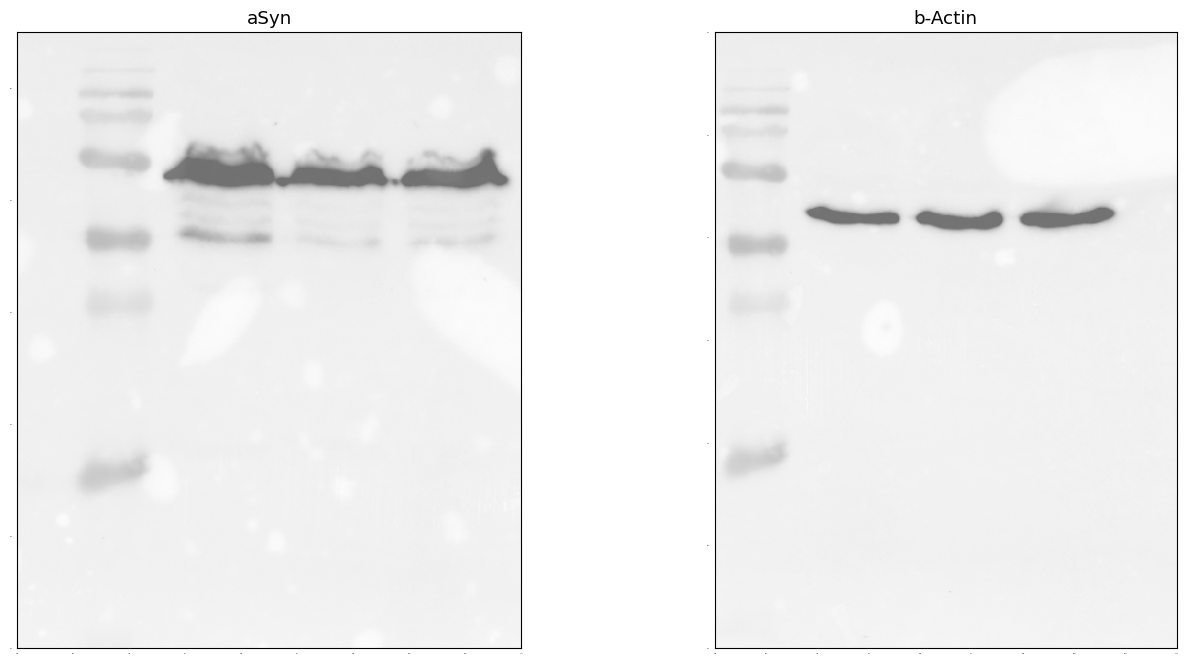

In [25]:
from skimage.io import imread

wb_one_path = os.path.join(wb_path,'1')
for im_file in glob.glob(os.path.join(wb_one_path, 'Raw Images','*(Composite)*.tif')):
    #print(im_file)
    continue
    
asyn_im = imread(copy_files(os.path.join(wb_one_path, 'Raw Images','Raphael 2022-12-05-7(Composite).tif')))
bactin_im = imread(copy_files(os.path.join(wb_one_path, 'Raw Images','asynstyx - bactin(Composite).tif')))

fig, axs = plt.subplots(figsize = (16,8), ncols=2)

axs[0].imshow(asyn_im)
axs[0].title.set_text('aSyn')
axs[0].set_ylim(600,50)
axs[0].set_xlim(650,1100)
axs[0].tick_params(which = 'both', size = 0, labelsize = 0)

axs[1].imshow(bactin_im)
axs[1].title.set_text('b-Actin')
axs[1].set_ylim(800,200)
axs[1].set_xlim(650,1100)
axs[1].tick_params(which = 'both', size = 0, labelsize = 0)

plt.show()

In [18]:
wb_one_df = read_densitometry(wb_one_path)

wb_one_df = normalize_dens(wb_one_df)

display(wb_one_df)

,b-Actin,aSyn,aSyn_rel,aSyn_norm
group,,,,
X,39108.865,53822.179,1.376214,1.000000
TP,42983.865,36880.501,0.858008,0.623455
FY,48857.492,40744.279,0.833941,0.605968


### Attempt 2
#### Seeding (15.06.2023)
- Seed 300.000 HeLa cells per well in 6 Well (diluted in 2mL DMEM)
- Layout:
    - 2 Wells per row per condition:
        Conditions: X, TP, FY

#### Transfection (16.06.2023)
- Change Media beforehand
- Transfect in a 1:2 manner (Plasmid1:Plasmid2)
- 0.1µg total amount of Plasmid per Well
- Conditions:
    - X: P1 = aSyn, P2 = STYX
    - TP: P1 = aSyn, P2 = TP-Linker-Protein
    - FY: P1 = aSyn, P2 = FY-Linker-Protein

- Change Media 4h after Transfection

#### Protein Extraction (17.06.2023)
- Change Media to 2mL PBS
- Incubate on ice for 20mins
- Replace PBS with 100µL RIPA(+PI)
- Incubate for 20mins
- Take out 100µL of cell lysate into 1.5mL Eppendorf tube
- Spin down @ max RPM for 20mins
- Take off 10µL for Protein Quantification:
    - Put into 96-Well
    - Put in BCA-Standard (3 Wells each)
    - Add 150µL Bradford-assay
    - Measure @660nm
    - Normalize volume:
        - Determine Volume to add to gel
        - Max Volume: 35µL for 10-slot comb, 25µL for 15-slot comb
        - Formula: Volume=(MaxV x MinC)/Conc
- Take off Supernatant
- Add LB
- Freeze

#### Western Blot (18.06.2023)
- Prepare 15% Polyacrylamide Gel
- Boil samples @97°C for 60s
- Add SizeMarker
- Add appropriate amounts of sample
- Run at 80V for 20mins
- Run as 130V until 10kD Marker at bottom
- Take out Gel and put into Transfer Buffer
- Transfer:
    - Put 5 Whattman Paper (WP) + Nitrocellulose membrane + Gel + 5 WP into Transfer-Machine
    - Run for 40mins
    - Take out membrane and out into TBST
    - Ponceau stain:
        - Stain with Ponceau S
        - Put back staining liquid into bottle
        - wash multiple times with H2O
        - Destain with TBST for 5mins
- Blocking:
    - Put Membrane into 5% Milk in TBST for 1h
- 1°AB - aSyn:
    - Put Anti-aSyn-AB into 5% BSA in TBST
    - Incubate Membrane in solution @ 4°C overnight
    
#### Imaging - GFP (19.06.2023)
- Wash in TBST for 3x for 5mins
- 2°AB - aSyn:
    - Put Anti-Mouse-AB into 5% Milk in TBST
    - Incubate Membrane in solution @ RT for 1h
- Wash in TBST for 3x for 5mins
- Add ECL to Membrane
- Image immediately
- Stripping:
    - Put Membrane in Stripping Buffer for 20mins
- Blocking:
    - Put Membrane into 5% Milk in TBST for 1h
- 1°AB - b-Actin:
    - Put Anti-b-Actin-AB into 5% BSA in TBST
    - Incubate Membrane in solution @ 4°C overnight
    
#### Imaging - b-Actin (20.06.2023)
- Wash in TBST for 3x for 5mins
- 2°AB - b-Actin:
    - Put Anti-Mouse-AB into 5% Milk in TBST
    - Incubate Membrane in solution @ RT for 1h
- Wash in TBST for 3x for 5mins
- Add ECL to Membrane
- Image immediately

#### Densitometry
- Draw rectangular ROI over each Protein
- Use "select first lane"
- Use "Plot lanes"
- Connect valleys with line tool
- Select each Area as ROI
- Save as  CSV using Protein as name

#### Results

['RawImages', 'Densitometry', 'Lanes.csv']


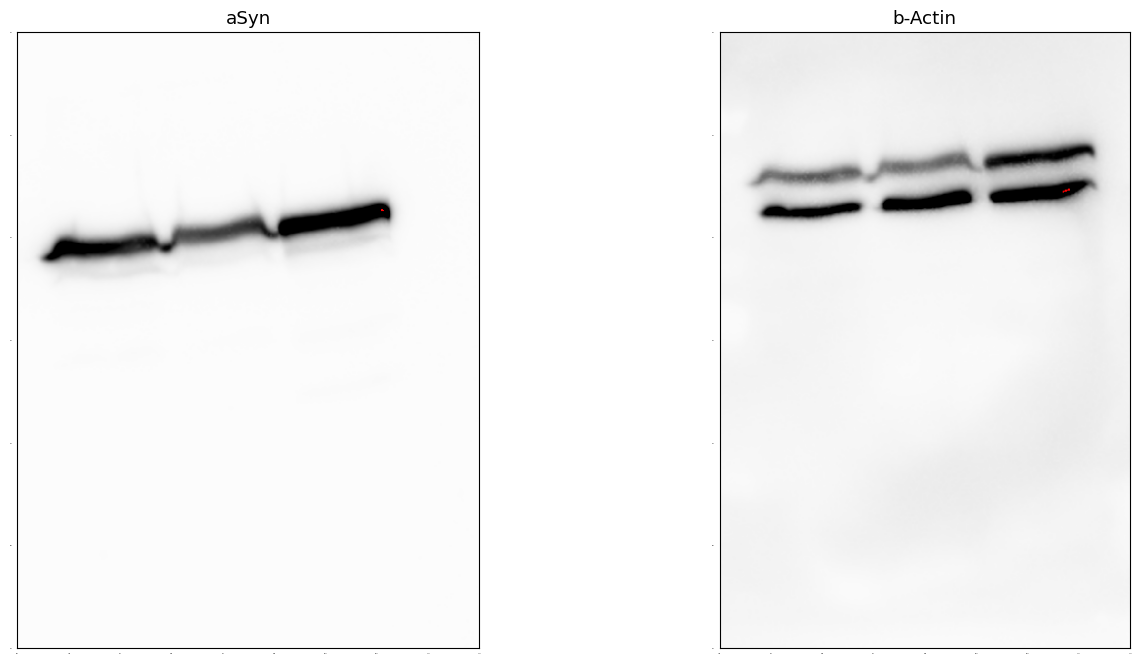

In [24]:
from skimage.io import imread

wb_two_path = os.path.join(wb_path,'2')
print(os.listdir(wb_two_path))
for im_file in glob.glob(os.path.join(wb_two_path, 'RawImages','*.tif')):
    #print(im_file)
    continue
    
asyn_im = imread(copy_files(os.path.join(wb_two_path, 'RawImages','Styx asyn(Chemiluminescence).tif')))
bactin_im = imread(copy_files(os.path.join(wb_two_path, 'RawImages','styx bactin(Chemiluminescence).tif')))

fig, axs = plt.subplots(figsize = (16,8), ncols=2)

axs[0].imshow(asyn_im)
axs[0].title.set_text('aSyn')
axs[0].set_ylim(800,200)
axs[0].set_xlim(700,1150)
axs[0].tick_params(which = 'both', size = 0, labelsize = 0)

axs[1].imshow(bactin_im)
axs[1].title.set_text('b-Actin')
axs[1].set_ylim(800,200)
axs[1].set_xlim(750,1150)
axs[1].tick_params(which = 'both', size = 0, labelsize = 0)

plt.show()

In [20]:
wb_two_df = read_densitometry(wb_two_path)

wb_two_df = normalize_dens(wb_two_df)

display(wb_two_df)

,aSyn,b-Actin,aSyn_rel,aSyn_norm
group,,,,
X,51750.794,36290.309,1.426022,1.000000
TP,34305.560,44454.702,0.771697,0.541153
FY,58562.329,54771.208,1.069217,0.749790


### Final Result

In [21]:
wb_df = pd.concat([wb_one_df.reset_index(),wb_two_df.reset_index()], ignore_index = True)
wb_result = result(df = wb_df)
wb_summary = wb_result.summarize(groups=['group'],values = 'aSyn_norm').round(3)
display(wb_summary)

,mean,sd,ci_lo,ci_hi,count
group,,,,,
X,1.000,0.000,1.000,1.000,2
TP,0.582,0.041,0.541,0.623,2
FY,0.678,0.072,0.606,0.750,2


In [22]:
wb_p = wb_result.create_p_table().set_index('group').round(3)

wb_summary['mean [CI]'] = wb_summary['mean'].astype(str) + ' [' + wb_summary['ci_lo'].astype(str) + ', ' + wb_summary['ci_hi'].astype(str) +']'

wb_final = wb_summary.loc[:,['mean [CI]']].join(wb_p)
display(wb_final.replace(np.nan, ''))

/home/raphael/miniforge3/envs/mdthesis/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,mean [CI],p,star
group,,,
X,"1.0 [1.0, 1.0]",,
TP,"0.582 [0.541, 0.623]",0.005,**
FY,"0.678 [0.606, 0.75]",0.023,*


/tmp/ipykernel_16405/2816328642.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Ctrl","TP","FY"])


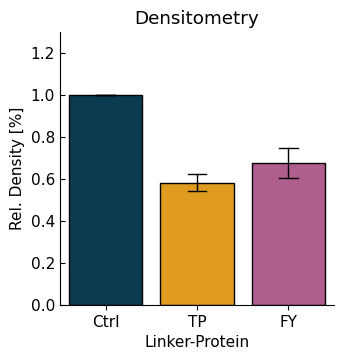

In [23]:
def prettify(ax, *args,
             title = None,
             x = ("x-axis", ""),
             y = ("y-axis", ""),
             **kwargs):
    ax.set_title(title)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel(x[0] if len(x[1])==0 else f"{x[0]} [{x[1]}]")
    ax.set_ylabel(y[0] if len(y[1])==0 else f"{y[0]} [{y[1]}]")
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which = "both", 
                   direction = "in",
                  axis = 'y')
    return ax

def boxplot(data, 
            x=None, 
            y=None ,
            ax=None, 
            y_scale = 1,
            **kwargs):
    datalist = [data.loc[data[x]==xs, y].values * y_scale for xs in data.loc[:,x].unique()]
    box = ax.boxplot(datalist,
                    positions = range(len(datalist)),
                    patch_artist=True,
                    showfliers=False,
                    **kwargs
                )
    return ax, box

fig,ax = plt.subplots(figsize = (3.54,3.54))
ax = sns.barplot(data = wb_df,
                x = "group",
                y = "aSyn_norm",
                hue = "group",
                legend = False,
                ax = ax,
                palette = ["#003f5c",
                     "#ffa600",
                     "#bc5090"],
                seed = 888,
                alpha = 1,
                capsize = 0.2,
                err_kws = {
                     "linewidth": 1,
                     "color":"0"
                })
ax = sns.barplot(data = wb_df,
                x = "group",
                y = "aSyn_norm",
                ax = ax,
                color = "k",
                fill = False,
                linewidth = 1,
                errorbar = None)
ax = prettify(ax,
              title = "Densitometry",
              x = ("Linker-Protein",""),
              y = ("Rel. Density","%"))
ax = prettify_boxplot(ax, box)
ax.set_xticklabels(["Ctrl","TP","FY"])
ax.set_ylim(0, 1.3)
plt.show()

## 